# Evaluation of 1 Model With Physgen

In [2]:
model_params_path = "../../checkpoints/best_checkpoint.pth"

# Output Paths -> will get cleared!!
output_base_dir = "../../data/eval"

# Data
physgen_variation = "sound_reflection"    # sound_baseline, sound_reflection, sound_diffraction, sound_combined
input_type = "osm"  # osm, base_simulation
output_type = "standard"  # standard, complex_only
fake_rgb_output = False
make_14_dividable_size = False
reflexion_channels = False
reflexion_steps = 36
reflexions_as_channels = False

### Imports

In [3]:
import sys
sys.path += "."

In [4]:
import os
import shutil
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cv2

import img_phy_sim as ips

In [5]:
!python --version

Python 3.13.9


In [6]:
os.listdir(".")

['eval_physgen_benchmark.ipynb',
 'inference.py',
 'test.py',
 'train.py',
 '__init__.py',
 '__pycache__']

In [7]:
os.path.abspath(".")

'd:\\Studium\\Master\\Repos\\Image-to-Image\\image_to_image\\model_interactions'

### Helper

In [8]:
output_dir = os.path.join(output_base_dir, "raw")
output_dir_cleaned = os.path.join(output_base_dir, "cleaned")
output_dir_evaluation = os.path.join(output_base_dir, "eval_results")

def clear_path(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        print(f"Cleaned path:'{path}'")
    else:
        os.makedirs(path, exist_ok=True)

clear_path(output_dir)
clear_path(output_dir_cleaned)
clear_path(output_dir_evaluation)

Cleaned path:'../../data/eval\raw'


In [9]:
def imshow(img, title=None, image_width=10, axis=False,
           color_space="RGB", cmap=None, cols=1, save_to=None,
           hspace=0.2, wspace=0.2,
           use_original_sytle=False, invert=False):
    """
    Visualizes one or multiple images.

    Image will be reshaped: [batch_size/images, width, height, channels]

    ---
    Parameters:
    - img : np.ndarray
        Images/Images with [width, height, channels] or for multiple: [batch_size/images, width, height, channels].
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    """
    original_style = plt.rcParams.copy()

    img_shape = img.shape
    print(f"Got images with shape: {img_shape}")

    # tranform the image to the right form
    if len(img_shape) == 2:
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) == 3:
        # check if multiple gray images or multiple images with channel
        # if img.shape[2] < img.shape[0] and img.shape[1] == img.shape[2]:
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], img.shape[2]))
        # else:
        #     # there could be cases where this is wrong
        #     img = np.reshape(img, shape=(img.shape[0], img.shape[1], img.shape[2], 1))
    elif len(img_shape) != 4:
        raise ValueError(f"Image(s) have wrong shape! Founded shape: {img.shape}.")

    print(f"Transformed shape to: {img_shape}")

    # invert images
    if invert:
        print("Invert images...")
        max_value = 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    # Set visualization settings
    # aspect_ratio_width = img.shape[1] / img.shape[2]
    aspect_ratio = img.shape[2] / img.shape[1]

    n_images = img.shape[0]
    rows = n_images//cols + int(n_images % cols > 0)

    width = int(image_width * cols)
    height = int(image_width * rows * aspect_ratio)

    # set plt style
    if not use_original_sytle:
        plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
        plt.style.use(plt_style)
        print(f"Using '{plt_style}' plotting style.")

    # plotting
    print(f"Making you a beautiful plot...")
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(width, height))
    try:
        ax = ax.ravel()
    except AttributeError:
        ax = [ax]
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    if type(title) == str:
        fig.suptitle(title, fontsize=128, y=0.95)

    for idx in range(len(ax)):
        cur_ax = ax[idx]

        if idx >= len(img):
            cur_ax.axis("off")
            continue

        cur_img = img[idx]

        if color_space.lower() == "bgr":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
            used_cmap = None
        elif color_space.lower() == "rgb":
            cur_img = cur_img
            used_cmap = None
        elif color_space.lower() == "hsv":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_HSV2RGB)
            used_cmap = None
        elif color_space.lower() in ["gray", "grey", "g"]:
            if len(cur_img.shape) == 3 and cur_img.shape[2]:
                cur_img = cv2.cvtColor(cur_img, cv2.COLOR_RGB2GRAY)
            else:
                cur_img = cur_img
            print(cur_img.shape)
            used_cmap = "gray"

        if cmap:
            used_cmap = cmap

        if type(title) in [list, tuple]:
            cur_ax.set_title(title[idx], fontsize=64)
        if axis == False:
            cur_ax.axis("off")

        cur_ax.imshow(cur_img, cmap=used_cmap)

    if save_to:
        os.makedirs(os.path.split(save_to)[0], exist_ok=True)
        fig.savefig(save_to, dpi=300)

    plt.show()

    if not use_original_sytle:
        # reset to original plt style
        plt.rcParams.update(original_style)

def show_images(image_paths:list, title=None, image_width=5, axis=False,
                color_space="gray", cmap=None, 
                cols=2, save_to=None,
                hspace=0.01, wspace=0.01,
                use_original_sytle=False, invert=False):
    """
    Visulalizes/shows one or multiple images.

    ---
    Parameters:
    - image_paths : List[str]
        List of paths to the images which should get visualized.
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    """
    if color_space.lower() == "rgb":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in image_paths])
    elif color_space.lower() == "hsv":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2HSV) for img in image_paths])
    else:
        images = np.array([cv2.imread(img) for img in image_paths])
    imshow(images, title=title, image_width=image_width, axis=axis,
           color_space=color_space, cmap=cmap, cols=cols, save_to=save_to,
           hspace=hspace, wspace=wspace,
           use_original_sytle=use_original_sytle, invert=invert)
    return images

### Run Tests

In [10]:
command = (
  f"python ../../main.py "
  f"--mode test "
  f"--output_dir {output_dir} "
  f"--model_params_path {model_params_path} "
  f"--data_variation {physgen_variation} "
  f"--input_type {input_type} "
  f"--output_type {output_type} "
)

if fake_rgb_output:
    command += f"--fake_rgb_output "

if make_14_dividable_size:
    command += f"--make_14_dividable_size "

if reflexion_channels:
    command += f"--reflexion_channels "
    command += f"--reflexion_steps {reflexion_steps} "
    if reflexions_as_channels:
        command += f"--reflexions_as_channels "

# Finally run it
!{command}

Running in mode: test
Using device: cuda
PhysGen (sound_reflection) Dataset for test got created
Used Loss: l1
Test Loss: 0.1418


d:\Programme\Anaconda\envs\img-to-img\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists

Validation: 100%|##########| 156/156 [00:11<00:00, 13.96it/s]


In [11]:
command = (
  f"python ../../main.py "
  f"--mode inference "
  f"--output_dir {output_dir} "
  f"--model_params_path {model_params_path} "
  f"--data_variation {physgen_variation} "
  f"--input_type {input_type} "
  f"--output_type {output_type} "
)

if fake_rgb_output:
    command += f"--fake_rgb_output "

if make_14_dividable_size:
    command += f"--make_14_dividable_size "

if reflexion_channels:
    command += f"--reflexion_channels "
    command += f"--reflexion_steps {reflexion_steps} "
    if reflexions_as_channels:
        command += f"--reflexions_as_channels "

# Finally run it
!{command}

Running in mode: inference
Using device: cuda
PhysGen (sound_reflection) Dataset for test got created
[0] Saved predictions to ../../data/eval\raw\buildings_0_fake_B.png
[1] Saved predictions to ../../data/eval\raw\buildings_1_fake_B.png
[2] Saved predictions to ../../data/eval\raw\buildings_2_fake_B.png
[3] Saved predictions to ../../data/eval\raw\buildings_3_fake_B.png
[4] Saved predictions to ../../data/eval\raw\buildings_4_fake_B.png
[5] Saved predictions to ../../data/eval\raw\buildings_5_fake_B.png
[6] Saved predictions to ../../data/eval\raw\buildings_6_fake_B.png
[7] Saved predictions to ../../data/eval\raw\buildings_7_fake_B.png
[8] Saved predictions to ../../data/eval\raw\buildings_8_fake_B.png
[9] Saved predictions to ../../data/eval\raw\buildings_9_fake_B.png
[10] Saved predictions to ../../data/eval\raw\buildings_10_fake_B.png
[11] Saved predictions to ../../data/eval\raw\buildings_11_fake_B.png
[12] Saved predictions to ../../data/eval\raw\buildings_12_fake_B.png
[13] Sav

d:\Programme\Anaconda\envs\img-to-img\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists

Inference:   0%|          | 0/156 [00:00<?, ?it/s]
                                                  

Inference:   1%|          | 1/156 [00:00<01:45,  1.46it/s]
                                                          

Inference:   1%|▏         | 2/156 [00:00<01:03,  2.43it/s]
                                                          

Inference:   2%|▏         | 3/156 [00:01<00:48,  3.13it/s]
                                                          

Inference:   3%|▎         | 4/156 [00:01<00:39,  3.88it/s]
                                                          

Inference:   3%|▎         | 5/156 [00:0

### Extract Test Predictions

Sort the predictions in sub folders.

In [12]:
!python ../utils/eval_extractor.py \
    --evaluation_path {output_dir} \
    --target_path {output_dir_cleaned}

[info] copied pred from '../../data/eval\raw\buildings_0_fake_B.png' to '../../data/eval\cleaned/pred\buildings_0.png'
[info] copied osm from '../../data/eval\raw\buildings_0_real_A.png' to '../../data/eval\cleaned/osm\buildings_0.png'
[info] copied real from '../../data/eval\raw\buildings_0_real_B.png' to '../../data/eval\cleaned/real\buildings_0.png'
[info] copied pred from '../../data/eval\raw\buildings_100_fake_B.png' to '../../data/eval\cleaned/pred\buildings_100.png'
[info] copied osm from '../../data/eval\raw\buildings_100_real_A.png' to '../../data/eval\cleaned/osm\buildings_100.png'
[info] copied real from '../../data/eval\raw\buildings_100_real_B.png' to '../../data/eval\cleaned/real\buildings_100.png'
[info] copied pred from '../../data/eval\raw\buildings_101_fake_B.png' to '../../data/eval\cleaned/pred\buildings_101.png'
[info] copied osm from '../../data/eval\raw\buildings_101_real_A.png' to '../../data/eval\cleaned/osm\buildings_101.png'
[info] copied real from '../../dat

### Calc Eval metrics

In [13]:
!python ../utils/physgen_benchmark.py \
    --data_dir {output_dir_cleaned}/real \
    --pred_dir {output_dir_cleaned}/pred \
    --osm_dir {output_dir_cleaned}/osm \
    --output {output_dir_evaluation}/evaluation.csv

              MAE        MAPE     LoS_MAE    NLoS_MAE   LoS_wMAPE  NLoS_wMAPE
count  156.000000  156.000000  156.000000  156.000000  156.000000  156.000000
mean    13.807702   56.798435   13.796214   13.832293   56.621330   56.905598
std      1.026346    5.280607    1.030293    1.040708    5.280314    5.492295
min     11.740005   45.979084   11.577927   11.267556   45.537773   44.603313
25%     13.130841   52.680691   13.031988   13.122227   52.731271   52.740707
50%     13.651918   56.219460   13.707591   13.780727   55.793133   56.774632
75%     14.538095   60.770499   14.428823   14.597337   60.398445   60.846880
max     16.297857   70.900475   16.183468   16.240406   70.175201   69.213028



Evaluating samples: 100%|██████████| 156/156 [00:29<00:00,  5.28it/s]


### Show Results

In [14]:
mae_model_1_name = f'MAE'
los_mae_model_1_name = f'LoS_MAE'
nlos_mae_model_1_name = f'NLoS_MAE'
mape_model_1_name = f'MAPE'
los_wmape_model_1_name = f'LoS_wMAPE'
nlos_wmape_model_1_name = f'NLoS_wMAPE'

In [15]:
df_1 = pd.read_csv(f"{output_dir_evaluation}/evaluation.csv")
# df_1 = df_1.drop(columns=["LoS_MAE", "NLoS_MAE", "LoS_wMAPE", "NLoS_wMAPE"])
df_1 = df_1.rename(columns={'MAE': mae_model_1_name, 
                            'LoS_MAE': los_mae_model_1_name,
                            'NLoS_MAE': nlos_mae_model_1_name,
                            'MAPE':mape_model_1_name,
                            'LoS_wMAPE': los_wmape_model_1_name,
                            'NLoS_wMAPE': nlos_wmape_model_1_name
                            }
                   )
# extract sample_ids
sample_id_series = df_1["sample_id"].str.extract(r'^(\d+)_')[0]
if sample_id_series.isna().sum() > 1:
    sample_id_series = df_1["sample_id"].str.extract(r'(\d+)')[0]
if sample_id_series.isna().sum() > 1:
    raise ValueError(f"Found {sample_id_series.isna().sum()} Nans")
df_1["sample_id"] = sample_id_series
print("Nan found in sample ids:", df_1["sample_id"].isna().sum())
df_1 = df_1.dropna(subset=["sample_id"])
df_1["sample_id"] = df_1["sample_id"].astype(int)
merged_df = df_1
df_1

Nan found in sample ids: 0


,sample_id,MAE,MAPE,LoS_MAE,NLoS_MAE,LoS_wMAPE,NLoS_wMAPE
0,0,13.968661,51.419106,14.164336,13.920300,52.364704,51.987804
1,1,14.693768,63.126167,14.331998,14.894381,63.286995,63.348495
2,10,14.336772,57.749560,14.316086,13.995411,57.742664,56.576410
3,100,13.447697,58.431736,13.798756,13.329461,60.559517,58.441204
4,101,14.998579,58.463130,15.064133,14.961288,58.798138,58.736057
...,...,...,...,...,...,...,...
151,95,14.262798,56.461720,14.107790,14.975336,56.099440,59.539215
152,96,14.167316,56.209330,14.112584,13.887898,55.748863,54.255154
153,97,13.401502,48.460730,13.466303,13.346726,48.677723,48.201640
154,98,13.648212,51.015377,13.333256,13.524361,49.219250,49.574318


Using 'seaborn-v0_8' plotting style.

LoS MAE: 13.80

NLoS MAE: 13.83

LoS wMAPE: 56.62

NLoS wMAPE: 56.91


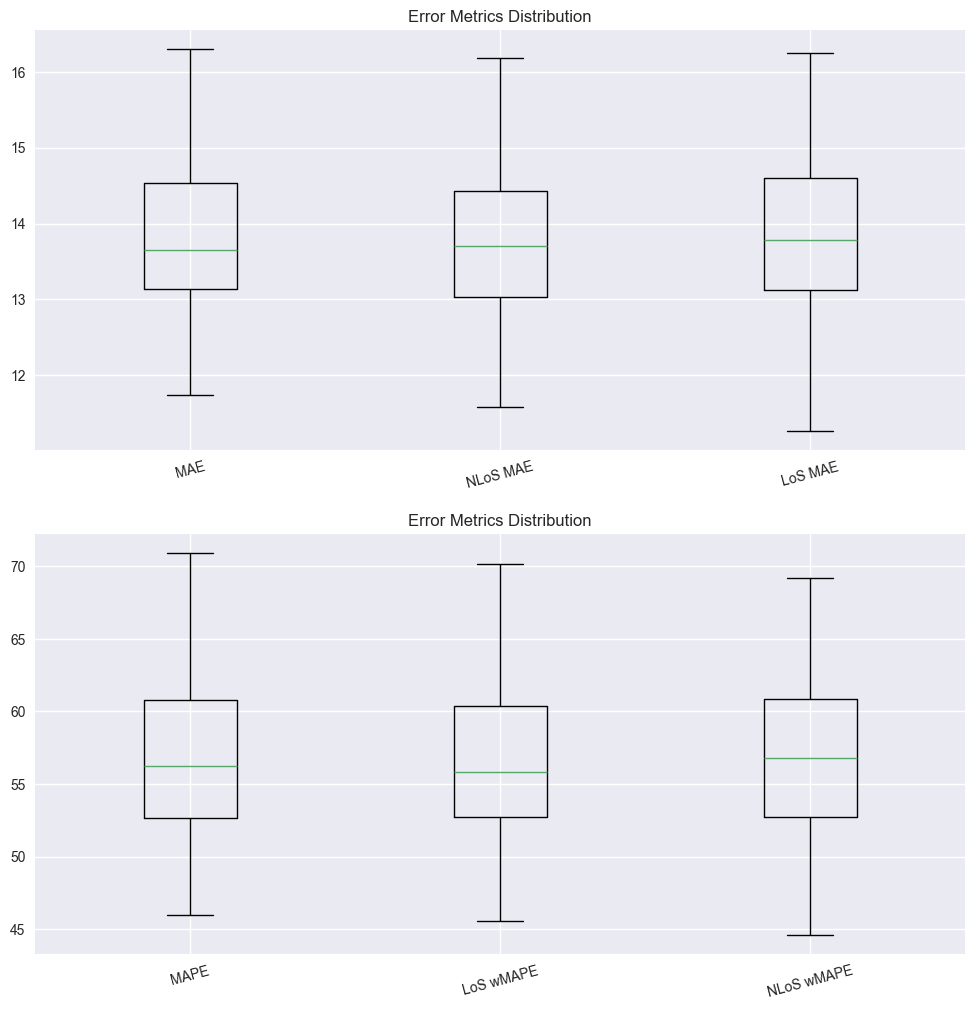

In [16]:
plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
plt.style.use(plt_style)
print(f"Using '{plt_style}' plotting style.")

values_0 = [
    merged_df[mae_model_1_name],
    merged_df[los_mae_model_1_name],
    merged_df[nlos_mae_model_1_name],
]

labels_0 = [
    "MAE",
    "NLoS MAE",
    "LoS MAE"
]

values_1 = [
    merged_df[mape_model_1_name],
    merged_df[los_wmape_model_1_name],
    merged_df[nlos_wmape_model_1_name]
]

labels_1 = [
    "MAPE",
    "LoS wMAPE",
    "NLoS wMAPE"
]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
ax[0].boxplot(values_0, notch=False)
ax[0].set_xticks(range(1, len(labels_0) + 1))
ax[0].set_xticklabels(labels_0, rotation=15)
ax[0].set_title("Error Metrics Distribution")

ax[1].boxplot(values_1, notch=False)
ax[1].set_xticks(range(1, len(labels_1) + 1))
ax[1].set_xticklabels(labels_1, rotation=15)
ax[1].set_title("Error Metrics Distribution")



# print(f"\nMAE\n    - {model_1}: {merged_df[mae_model_1_name].mean():>0.2f}")
# print(f"\nMAPE\n    - {model_1}: {merged_df[mape_model_1_name].mean():>0.2f}")

print(f"\nLoS MAE: {merged_df[los_mae_model_1_name].mean():>0.2f}")
print(f"\nNLoS MAE: {merged_df[nlos_mae_model_1_name].mean():>0.2f}")
print(f"\nLoS wMAPE: {merged_df[los_wmape_model_1_name].mean():>0.2f}")
print(f"\nNLoS wMAPE: {merged_df[nlos_wmape_model_1_name].mean():>0.2f}")

Example Image

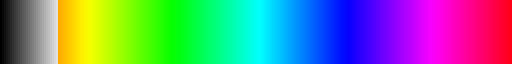

In [17]:
from matplotlib.colors import ListedColormap

def get_unique_hsv_cmap():
    unique_hsv_map = plt.get_cmap("hsv")(np.linspace(0, 1, 256))    # np.arange(0, 256)
    hsv_map = plt.get_cmap("hsv")
    for cur_idx in range(256):
        r, g, b, a = hsv_map(cur_idx)
        if r > 0.99 and g < (170/255):
            gray_value = cur_idx*8 / 255.0
            unique_hsv_map[cur_idx] = (gray_value, gray_value, gray_value, 1.0)
        else:
            break
    unique_hsv = ListedColormap(unique_hsv_map)
    plt.colormaps.register(name="unique_hsv", cmap=unique_hsv, force=True)
    return unique_hsv

get_unique_hsv_cmap()
plt.get_cmap("unique_hsv")

In [18]:
def get_same_pred_real_samples(pred_path:str, real_path:str, input_path:str, n_samples:int, ids=None):
    if not ids:
        # choose n random samples
        samples = random.sample(os.listdir(pred_path), n_samples)
        pred_samples = [os.path.join(pred_path, cur_image) for cur_image in samples]

        # get the used id's
        ids = []
        for cur_image in samples:
            cur_id = re.findall(r'\d+', string=cur_image)
            if len(cur_id) <= 0:
                raise ValueError(f"One image has no ID: {cur_image}")
            cur_id = cur_id[-1]
            ids += [cur_id]
    else:
        # get pred image
        pred_image_samples = []
        for target_id in ids:
            found = False
            for cur_image in os.listdir(real_path):
                cur_id = re.findall('\d+', string=cur_image)
                if len(cur_id) > 0:
                    cur_id = cur_id[-1]
                    if cur_id == target_id:
                        pred_image_samples += [cur_image]
                        found = True
                        break

            if not found:
                raise ValueError(f"Does not found pred image with id: {target_id}")
        pred_samples = [os.path.join(pred_path, cur_image) for cur_image in pred_image_samples]

    # get real image
    real_image_samples = []
    for target_id in ids:
        found = False
        for cur_image in os.listdir(real_path):
            cur_id = re.findall('\d+', string=cur_image)
            if len(cur_id) > 0:
                cur_id = cur_id[-1]
                if cur_id == target_id:
                    real_image_samples += [cur_image]
                    found = True
                    break

        if not found:
            raise ValueError(f"Does not found real image with id: {target_id}")

    target_samples = [os.path.join(real_path, cur_image) for cur_image in real_image_samples]

    # get real image
    input_image_samples = []
    if input_path:
        for target_id in ids:
            found = False
            for cur_image in os.listdir(input_path):
                cur_id = re.findall('\d+', string=cur_image)
                if len(cur_id) > 0:
                    cur_id = cur_id[-1]
                    if cur_id == target_id:
                        input_image_samples += [cur_image]
                        found = True
                        break

            if not found:
                raise ValueError(f"Does not found input image with id: {target_id}")

    input_samples = [os.path.join(input_path, cur_image) for cur_image in input_image_samples]

    return input_samples, target_samples, pred_samples, ids

<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
C:\Users\tobia\AppData\Local\Temp\ipykernel_9684\1596793078.py:21: SyntaxWarning: invalid escape sequence '\d'
  cur_id = re.findall('\d+', string=cur_image)
C:\Users\tobia\AppData\Local\Temp\ipykernel_9684\1596793078.py:38: SyntaxWarning: invalid escape sequence '\d'
  cur_id = re.findall('\d+', string=cur_image)
C:\Users\tobia\AppData\Local\Temp\ipykernel_9684\1596793078.py:57: SyntaxWarning: invalid escape sequence '\d'
  cur_id = re.findall('\d+', string=cur_image)


In [19]:
def plot(ax, path, title="", sub_image=None, cmap="turbo", plot=True, normalize=True, vmin=0.0, vmax=1.0):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    # print("\n", title, img.max())
    # print("\n", title, img.min())
    img = 255 - img
    # print(img.max())

    if sub_image:
        img_2 = cv2.imread(sub_image, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img_2 = 255 - img_2

        assert img_2.shape == img.shape, "Shape mismatch"
        img = np.abs(img - img_2)
        # img = img - img_2
        # img[img < 0] = img[img < 0] * -1

    # print(title, img.max())

    # normalize
    if normalize:
        img = img / 255.0
        if sub_image:
            img_2 = img_2 / 255.0

    # print(title, img.max())

    if plot:
        ax.axis("off")
        color_ax = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title)
        plt.colorbar(color_ax, ax=ax, fraction=0.046, pad=0.04)
    
    return img

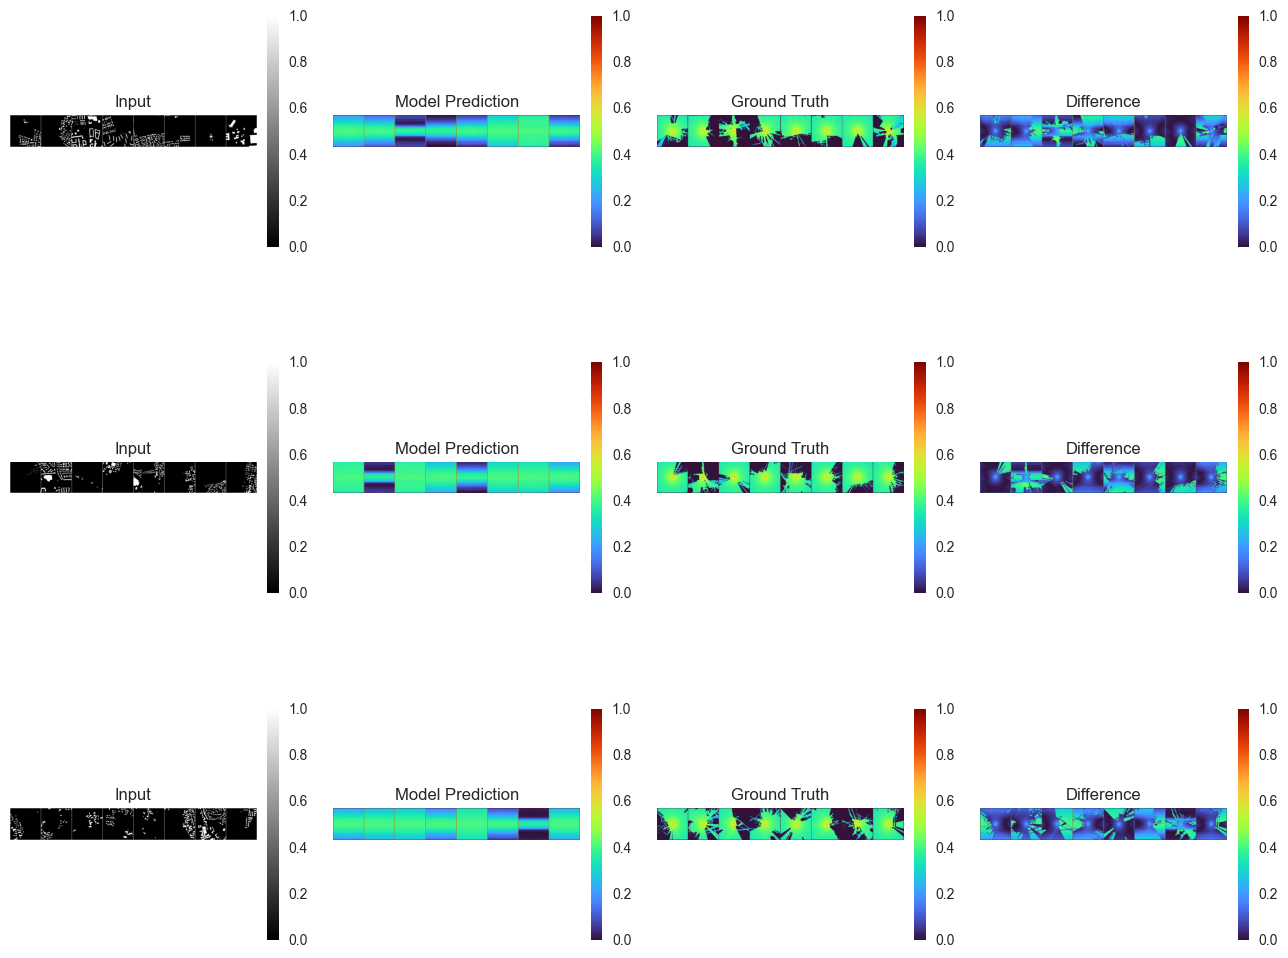

In [20]:
n_samples = 3

input_samples, real, pred_model, ids = get_same_pred_real_samples(f"{output_dir_cleaned}/pred",
                                                                  f"{output_dir_cleaned}/real",
                                                                  f"{output_dir_cleaned}/osm",
                                                                  n_samples)


fig, ax = plt.subplots(nrows=n_samples, ncols=4, figsize=(4*4, n_samples*4))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(input_samples):
    plot(ax[idx][0], path=cur_path, title=f"Input", cmap="gray")

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][1], path=cur_path, title=f"Model Prediction")  #, vmax=100)

for idx, cur_path in enumerate(real):
    plot(ax[idx][2], path=cur_path, title=f"Ground Truth")  # , vmax=100)

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][3], path=cur_path, title=f"Difference", sub_image=real[idx])

plt.subplots_adjust(hspace=0.5)

plt.show();

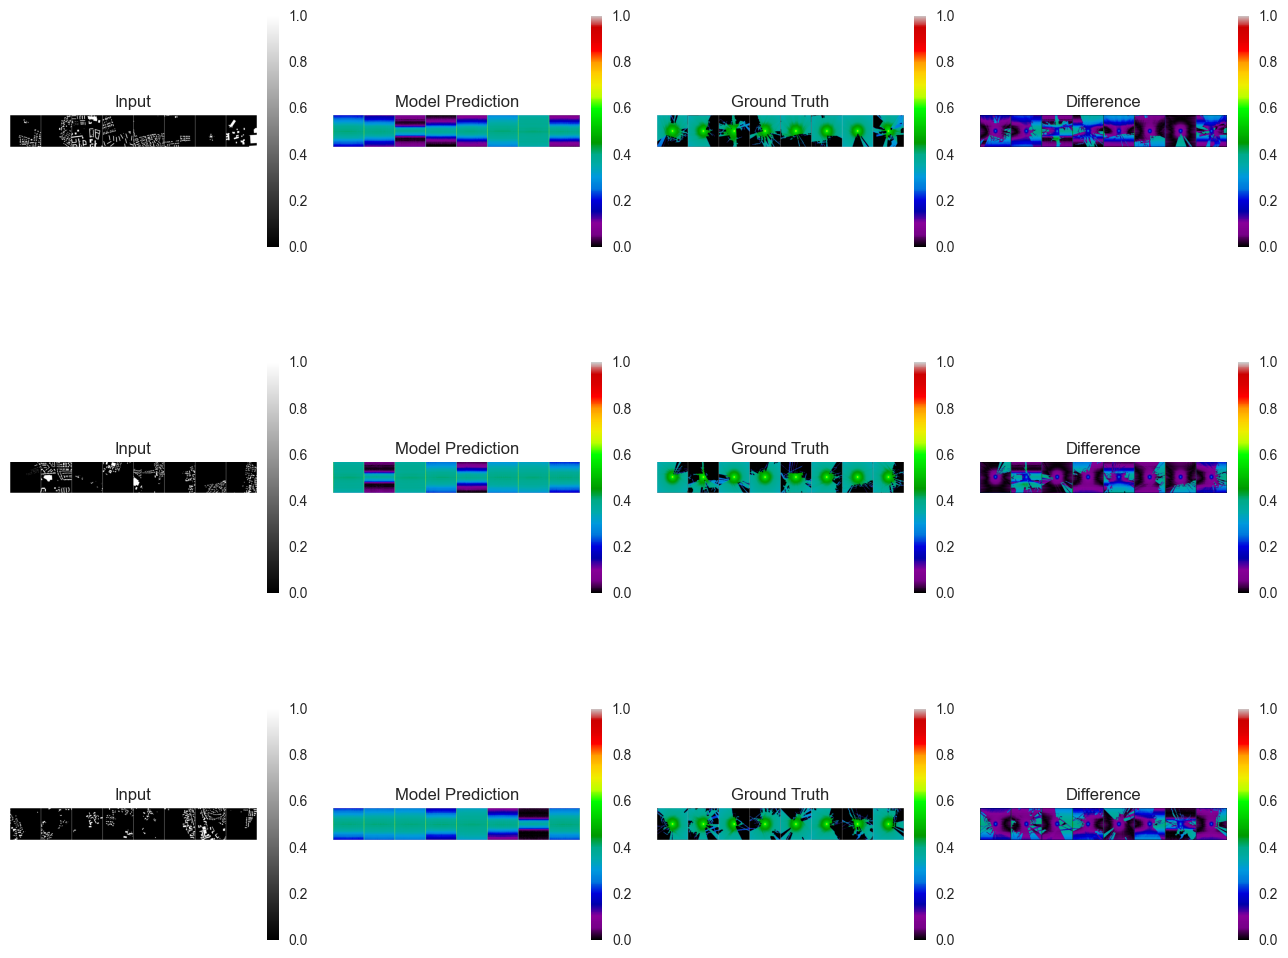

In [21]:
fig, ax = plt.subplots(nrows=n_samples, ncols=4, figsize=(4*4, n_samples*4))
# ax = ax.ravel()

ax_idx = 0

cur_cmap = "nipy_spectral"

for idx, cur_path in enumerate(input_samples):
    plot(ax[idx][0], path=cur_path, title=f"Input", cmap="gray")

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][1], path=cur_path, title=f"Model Prediction", cmap=cur_cmap)  #, vmax=100)

for idx, cur_path in enumerate(real):
    plot(ax[idx][2], path=cur_path, title=f"Ground Truth", cmap=cur_cmap)  # , vmax=100)

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][3], path=cur_path, title=f"Difference", sub_image=real[idx], cmap=cur_cmap)

plt.subplots_adjust(hspace=0.5)

plt.show();

Little check with another lib

(0, 0, 0)
<PIL.Image.Image image mode=L size=2066x260 at 0x2648007EE10>
np_img.min()=np.uint8(0), np_img.max()=np.uint8(255)


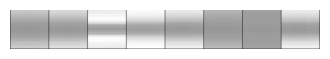

In [22]:
from PIL import Image

img = Image.open(pred_model[0])
print(img.getpixel((0, 0)))
print(img.getchannel(0))
np_img = np.array(img)
print(f"{np_img.min()=}, {np_img.max()=}")
ips.img.imshow(np_img, size=4, axis_off=True, cmap="gray")

Another CMaps

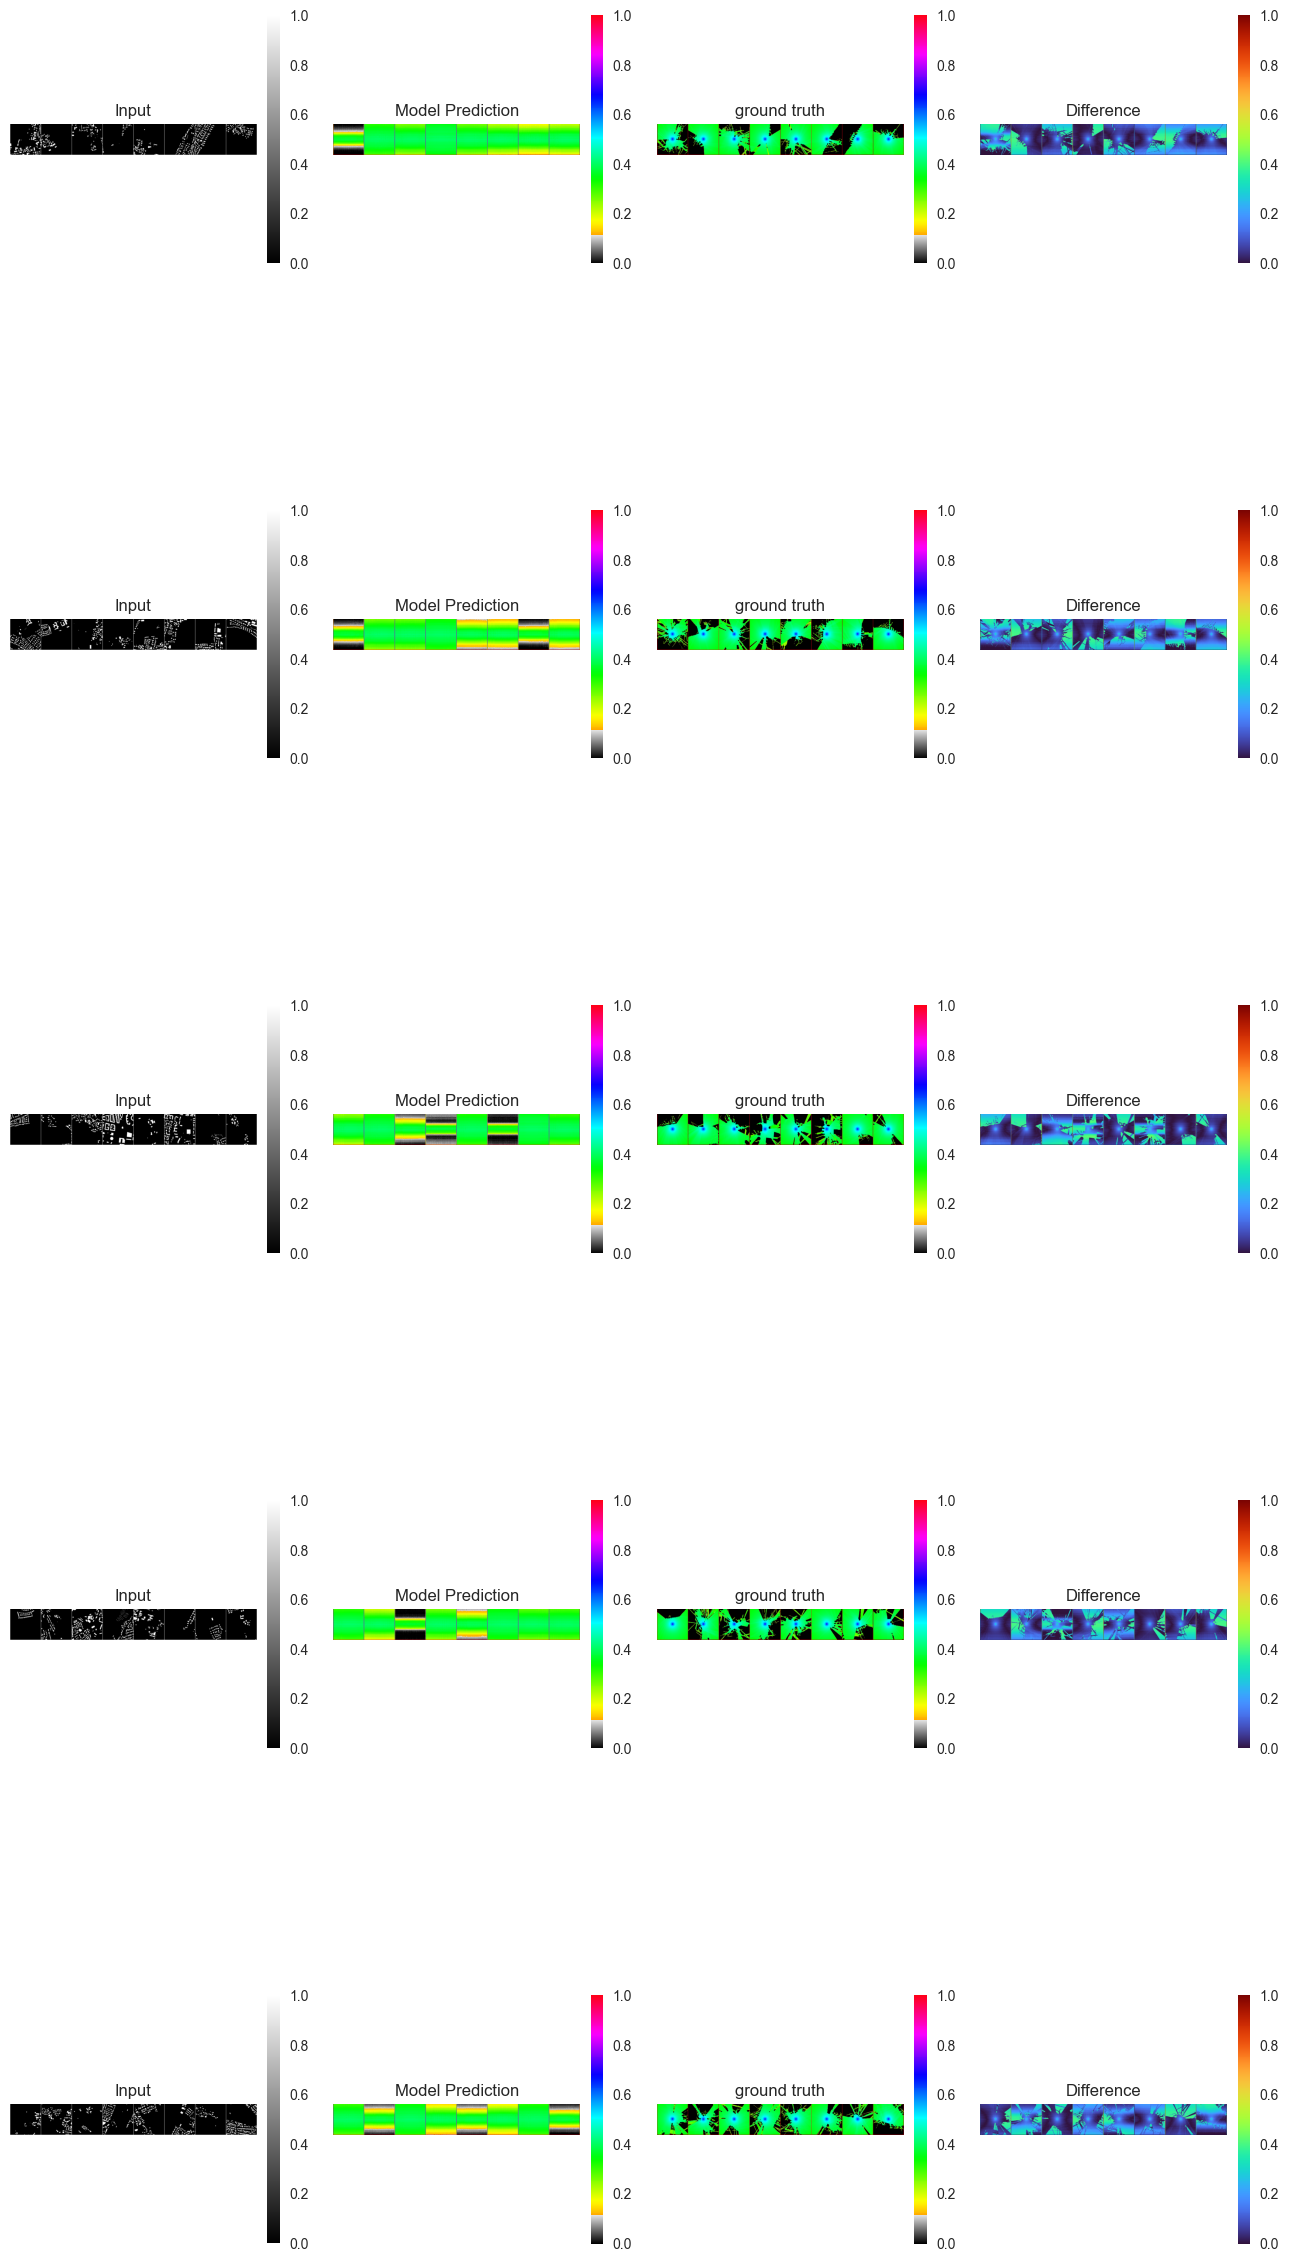

In [23]:
n_samples = 5

input_samples, real, pred_model, ids = get_same_pred_real_samples(f"{output_dir_cleaned}/pred",
                                                                  f"{output_dir_cleaned}/real",
                                                                  f"{output_dir_cleaned}/osm",
                                                                  n_samples)


fig, ax = plt.subplots(nrows=n_samples, ncols=4, figsize=(4*4, n_samples*6))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(input_samples):
    plot(ax[idx][0], path=cur_path, title=f"Input", cmap="gray")

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][1], path=cur_path, title=f"Model Prediction", cmap="unique_hsv")

for idx, cur_path in enumerate(real):
    plot(ax[idx][2], path=cur_path, title=f"ground truth", cmap="unique_hsv")

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][3], path=cur_path, title=f"Difference", sub_image=real[idx])

plt.subplots_adjust(hspace=0.5)

plt.show();

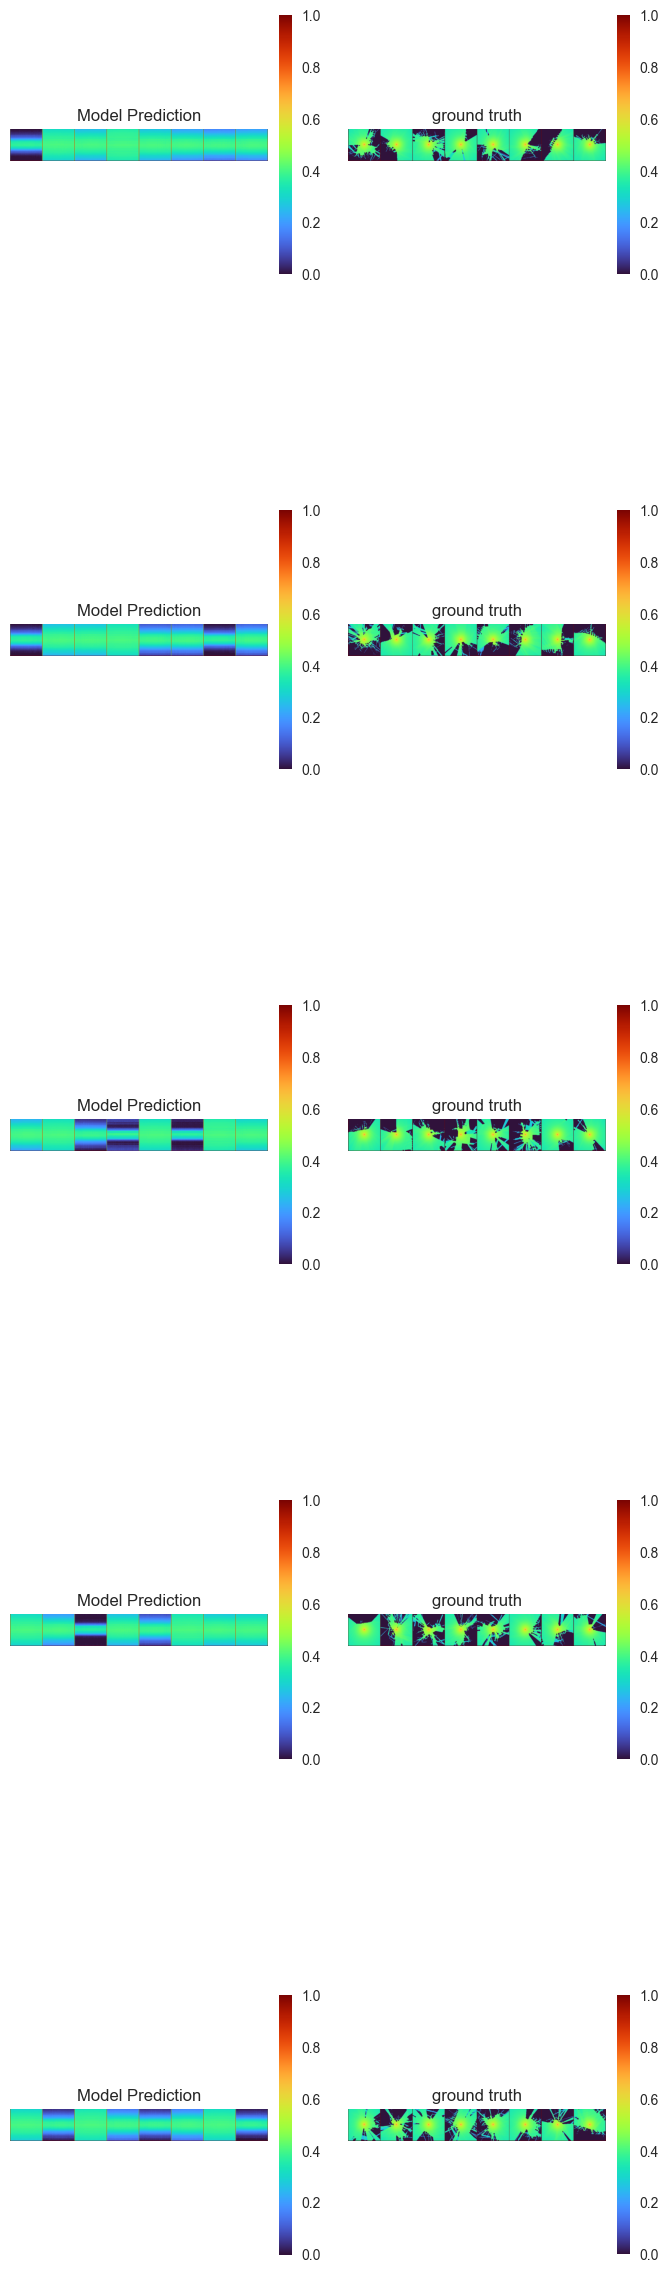

In [24]:
fig, ax = plt.subplots(nrows=n_samples, ncols=2, figsize=(2*4, n_samples*6))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][0], path=cur_path, title=f"Model Prediction")

for idx, cur_path in enumerate(real):
    plot(ax[idx][1], path=cur_path, title=f"ground truth")

plt.subplots_adjust(hspace=0.5)

plt.show();

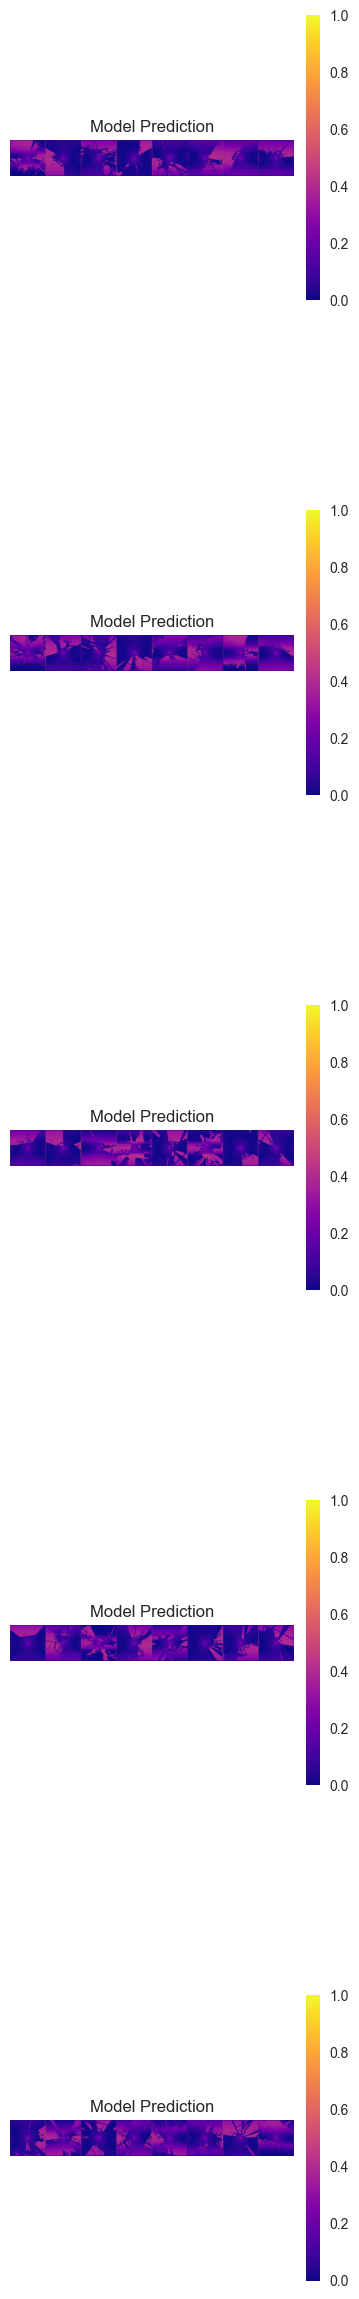

In [25]:
fig, ax = plt.subplots(nrows=n_samples, ncols=1, figsize=(1*4, n_samples*6))

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx], path=cur_path, title=f"Model Prediction", sub_image=real[idx], cmap="plasma")

plt.subplots_adjust(hspace=0.5)
plt.show();

Inspect some single images in more detail here:

In [26]:
from skimage.measure import block_reduce

def plot_image_with_values(img, block_size=8):
    # Compute mean over non-overlapping blocks
    mean_img = block_reduce(img, block_size=(block_size, block_size), func=np.mean)
    max_value = mean_img.max()

    # Plot the mean image
    plt.imshow(mean_img, cmap='gray', interpolation='nearest')
    plt.colorbar(label='Mean Value')

    # Annotate each block with the mean
    for i in range(mean_img.shape[0]):
        for j in range(mean_img.shape[1]):
            val = mean_img[i, j]
            color = 'white' if val < max_value/1.5 else 'black'
            # color = int(255 - val)
            plt.text(j, i, f'{val:.1f}', ha='center', va='center',
                     color=color, fontsize=6)

    plt.title(f'Mean Values over {block_size}x{block_size} Blocks')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

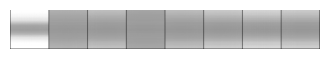

In [27]:
img_path = pred_model[0]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(float)

ips.img.imshow(img, size=4, axis_off=True, cmap="gray")

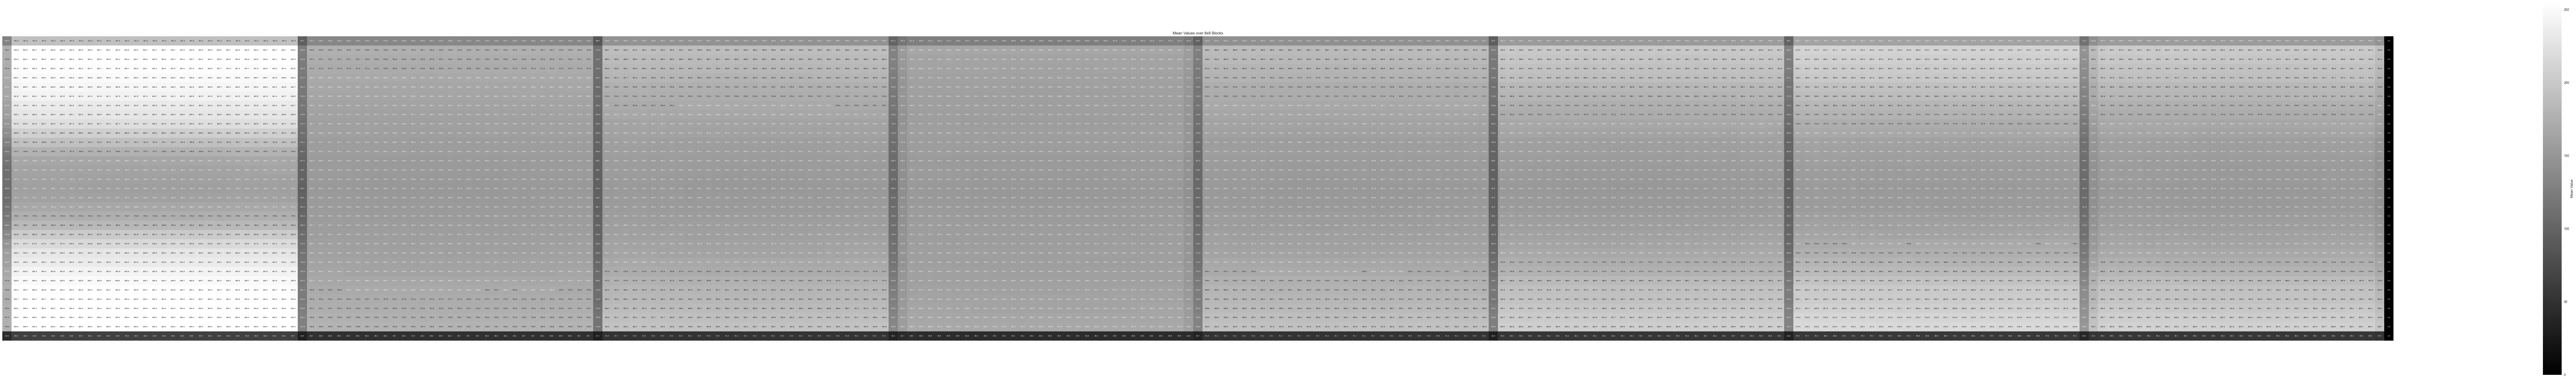

In [28]:
ips.img.plot_image_with_values(img, block_size=8, cmap='gray', title=None, 
                               font_size=6, save_to=None)

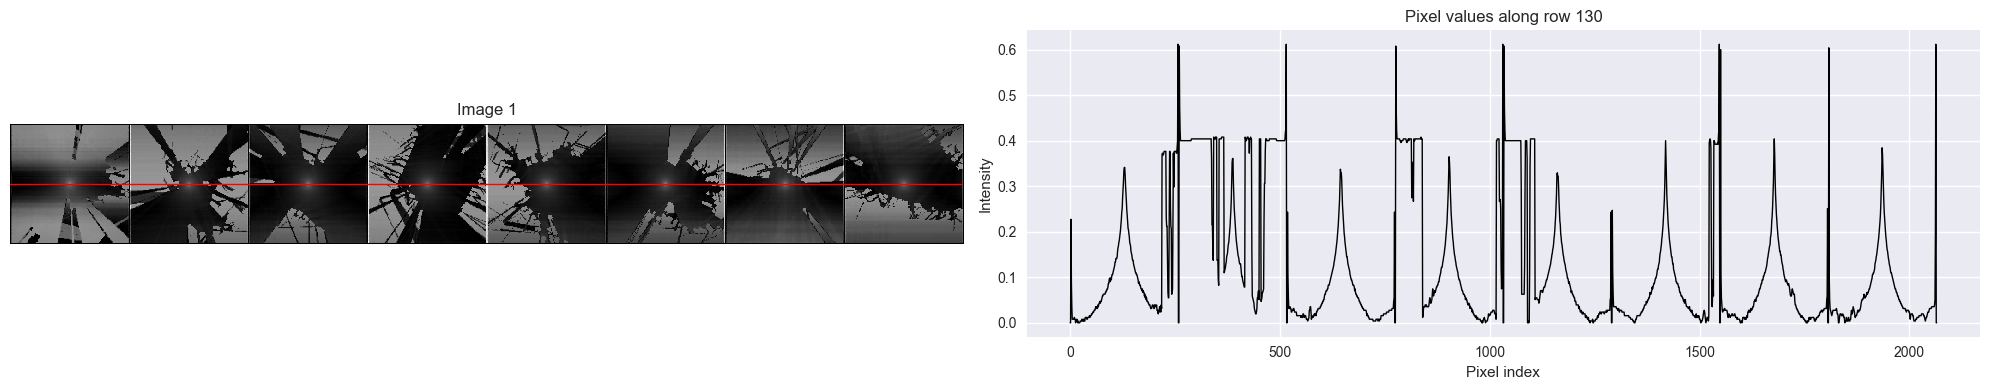

[array([0.        , 0.        , 0.22745098, ..., 0.6117647 , 0.        ,
        0.        ], shape=(2066,), dtype=float32)]

In [29]:
img = plot(None, path=pred_model[0], title=f"Model Prediction", sub_image=real[idx], plot=False)
ips.img.show_image_with_line_and_profile([img], axis='row', index=None, titles=None, figsize=(10, 4))